## Strange Network Development

In [2]:
import rasterio
import keras
import random
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, Bidirectional
from keras.layers import Conv2D, MaxPooling2D, ConvLSTM2D, TimeDistributed, UpSampling2D, Concatenate, LSTM, concatenate
from keras.layers import Activation, BatchNormalization
from keras.optimizers import SGD, Adadelta, Adam
from keras import Input
from keras import Model
import matplotlib.pyplot as plt
import os
import sys
from sklearn.utils import class_weight
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import utilities as util
import importlib
import rnn_tiles
import rnn_pixels
import numpy as np

In [39]:
importlib.reload(rnn_pixels)
importlib.reload(rnn_tiles)
importlib.reload(util)

<module 'utilities' from '/host/Desktop/florence_mapping/utilities.py'>

Assign your specific GPU so we don't overlap

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="1";

Is that GPU and only that GPU visible?

Note that it will always say GPU:0 but you should just see one

In [4]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

Ingest Training Labels

Note that these are monster files so be careful how you inspect them, typically you only want to use the `rasterio` windows option

In [5]:
lc_labels = rasterio.open('/deep_data/recurrent_data/NLCD_DATA/landcover/NLCD_2011_Land_Cover_L48_20190424.img')
canopy_labels = rasterio.open('/deep_data/recurrent_data/NLCD_DATA/canopy/CONUSCartographic_2_8_16/Cartographic/nlcd2011_usfs_conus_canopy_cartographic.img')

Ingest the landsat imagery stacked into yearly seasonal tiles

In [6]:
tiles = {}
landsat_datasets = {}
tiles['028012'] = ['20110324', '20110612', '20110831', '20111103']
tiles['029011'] = ['20110308', '20110425', '20110831', '20111103']
tiles['028011'] = ['20110308', '20110628', '20110831', '20111103']
for tile_number, dates in tiles.items():
    tile_datasets = []
    l8_image_paths = []
    for date in dates:
        l8_image_paths.append('/deep_data/recurrent_data/tile{}/combined/combined{}.tif'.format(tile_number, date))
    for fp in l8_image_paths:
        tile_datasets.append(rasterio.open(fp))
    landsat_datasets[tile_number] = tile_datasets

In [7]:
tile_size = 7
tile_list = ['028012', '029011', '028011']
class_count = 6
epochs = 200
batch_size = 25

# The next two cells are for making pixels and prepping them for training (balancing)
### This is unnecessary to run because I already saved them to text files so now you load them

In [48]:
px = rnn_pixels.make_pixels(tile_size, tile_list)
px_to_use = px[:5000000]
pixels = rnn_pixels.delete_bad_tiles(landsat_datasets,lc_labels, canopy_labels, px_to_use, tile_size)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000
15

1164000
1165000
1166000
1167000
1168000
1169000
1170000
1171000
1172000
1173000
1174000
1175000
1176000
1177000
1178000
1179000
1180000
1181000
1182000
1183000
1184000
1185000
1186000
1187000
1188000
1189000
1190000
1191000
1192000
1193000
1194000
1195000
1196000
1197000
1198000
1199000
1200000
1201000
1202000
1203000
1204000
1205000
1206000
1207000
1208000
1209000
1210000
1211000
1212000
1213000
1214000
1215000
1216000
1217000
1218000
1219000
1220000
1221000
1222000
1223000
1224000
1225000
1226000
1227000
1228000
1229000
1230000
1231000
1232000
1233000
1234000
1235000
1236000
1237000
1238000
1239000
1240000
1241000
1242000
1243000
1244000
1245000
1246000
1247000
1248000
1249000
1250000
1251000
1252000
1253000
1254000
1255000
1256000
1257000
1258000
1259000
1260000
1261000
1262000
1263000
1264000
1265000
1266000
1267000
1268000
1269000
1270000
1271000
1272000
1273000
1274000
1275000
1276000
1277000
1278000
1279000
1280000
1281000
1282000
1283000
1284000
1285000
1286000
1287000
1288000


In [49]:
len(pixels)

433304

In [ ]:
# gets balanced pixels locations 
w_tile_gen = rnn_tiles.rnn_tile_gen(landsat_datasets, lc_labels, canopy_labels, tile_size, class_count)
w_generator = w_tile_gen.tile_generator(pixels, batch_size=1, flatten=True, canopy=False)
total_labels = list()
count = 0
#buckets = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[]}
buckets = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[]}

while count < len(pixels):
        image_b, label_b = next(w_generator)
        label_b = np.argmax(label_b)
        buckets[label_b].append(pixels[count]) # appends pixels to dictionary
        total_labels.append(label_b)
        count+=1
total_labels = np.asarray(total_labels)
total_labels = total_labels.reshape(len(total_labels))
#weights_list = class_weight.compute_class_weight('balanced', np.unique(total_labels), total_labels)
count = 0 
for z, j in buckets.items():
    print(len(j))
    count += len(j)
print(count) 
use_px = []
use_px+=buckets[0][:3000]
use_px+=(buckets[1][:3000])
use_px+=(buckets[2][:3000])
use_px+=(buckets[3][:3000])
use_px+=(buckets[4][:3000])
use_px+=(buckets[5][:3000])
random.shuffle(use_px)
train_px, val_px, test_px = rnn_pixels.train_val_test_split(use_px, 0.7, 0.7)

In [ ]:
len(buckets[4])

# Load pixels

In [ ]:
#train_px, val_px, test_px = util.read_txt(['train_px.txt', 'val_px.txt', 'test_px.txt'])
#train_px = rnn_pixels.delete_bad_tiles(landsat_datasets,lc_labels, canopy_labels, train_px, tile_size)
#val_px =  rnn_pixels.delete_bad_tiles(landsat_datasets,lc_labels, canopy_labels, val_px, tile_size)
#test_px =  rnn_pixels.delete_bad_tiles(landsat_datasets,lc_labels, canopy_labels, test_px, tile_size)

### Create the RNN

In [ ]:
def strangeBlock_v4(input_block, nb_layers, filters):
    x_list = [input_block]
    c_temp = input_block
    for i in range(nb_layers):
        c_l = LSTM(units=filters, activation='elu', return_sequences=True) (c_temp)
        x_list.append(c_l)
        merge = Concatenate()(x_list)
        c_temp = merge
    return c_temp
    

In [36]:
def make_MLT_dense(in_shape, in_shape_tile, num_classes):
    input_tensor = Input(shape = in_shape, name="rnn_input")
    #single pixel model
    block = strangeBlock_v4(input_tensor, 5, 12)
    block_2 = strangeBlock_v4(block, 3, 20)
    final_block = LSTM(64, activation='softmax', return_sequences=False) (block_2)

    #cnn model
    input_tensor_tile = Input(shape = in_shape_tile, name="tile_input")
    cnn_layer1 = ConvLSTM2D(64, kernel_size=2, activation='elu', return_sequences=True)(input_tensor_tile)
    # batch norm
    cnn_layer2 = ConvLSTM2D(64, kernel_size=2, activation='elu', return_sequences=False) (cnn_layer1)
    maxpool = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid') (cnn_layer2)
    flatten = Flatten()(maxpool)
    concat = concatenate([final_block, flatten])
    
    landcover = Dense(num_classes,activation='softmax', name='landcover') (concat)
    canopy = Dense(1, name='canopy') (concat)

    model = Model(inputs=[input_tensor,input_tensor_tile], outputs=[landcover, canopy])
    return model

In [ ]:
model = make_MLT_dense((4,7),(4,tile_size,tile_size,7), 6)
#model.load_weights('mlt_dense_model.hdf5')
model.summary()

In [ ]:
#model = keras.models.load_model('dense_model.h5')

#### Train the Model

In [ ]:
#filepath = 'mlt_dense_model_pcg.hdf5'#your filepath here
#checkpoint = ModelCheckpoint(filepath, monitor='val_landcover_acc', verbose=1, save_best_only=True, mode='max')
#callbacks_list = [checkpoint]
tile_gen = rnn_tiles.rnn_tile_gen(landsat_datasets, lc_labels, canopy_labels, tile_size, class_count)

In [ ]:
model.compile(optimizer=Adam(), loss={'landcover':'categorical_crossentropy', 'canopy':'mae'}, metrics={'landcover':['accuracy'], 'canopy':['mae']}, loss_weights={"landcover":1, "canopy":1})

In [ ]:
model.fit_generator(generator=tile_gen.tile_generator(train_px, batch_size, flatten=True, canopy=True), 
                    steps_per_epoch=len(train_px) // batch_size, epochs=epochs, verbose=1,
                   validation_data=tile_gen.tile_generator(val_px, batch_size, flatten=True, canopy=True),
                  validation_steps=len(val_px) // batch_size)# callbacks=callbacks_list)# class_weight=weights_list)# callbacks=callbacks_list) #class_weight=weights, callbacks=callbacks_list) 

### Inspect Training Data

In [ ]:
predictions = model.predict_generator(generator = tile_gen.tile_generator(train_px, batch_size=1, flatten=True, canopy=True), steps=len(train_px) // 1, verbose=1)
eval_generator = tile_gen.tile_generator(train_px, batch_size=1, flatten=True, canopy=True)

In [ ]:
lc_predictions_train = np.asarray(predictions[0])
canopy_pred_train = np.asarray(predictions[1])
lc_predictions_train = np.argmax(lc_predictions_train,axis=-1)

In [ ]:
lc_lab_train = np.empty(lc_predictions_train.shape)
canopy_true_train = np.empty(canopy_pred_train.shape)
count = 0
while count < len(lc_predictions_train):
        image_b, label_b = next(eval_generator)
        #label_b = np.argmax(label_b, axis=-1)
        label_lc = np.argmax(label_b['landcover'], axis=-1)
        canopy_true_train[count] = label_b['canopy']
        lc_lab_train[count] = label_lc
        count += 1
label_index = lc_lab_train.reshape(len(train_px)*tile_size*tile_size)
pred_index = lc_predictions_train.reshape(len(train_px)*tile_size*tile_size)

In [ ]:
plt.hist(canopy_true_train, alpha=0.75), plt.hist(canopy_pred_train, alpha=0.5)

In [ ]:
from sklearn.metrics import r2_score
r2_score(canopy_true_train, canopy_pred_train)

In [ ]:
from scipy.stats import gaussian_kde

x = (canopy_pred_train * 100).flatten()
y = (canopy_true_train * 100).flatten()

xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

idx = z.argsort()

fig,ax = plt.subplots()
ax.scatter(x,y,c=z,s=50,edgecolor='')
ax.set_xlabel("Predictions")
ax.set_ylabel("Annotations")
ax.set_title("Canopy Cover Predictions")
plt.show()

# Evaluate model

In [43]:
predictions = model.predict_generator(generator = tile_gen.tile_generator(val_px, batch_size=1, flatten=True, canopy=True), steps=len(test_px) // 1, verbose=1)
eval_generator = tile_gen.tile_generator(val_px, batch_size=1, flatten=True, canopy=True)

2400/2400 [==============================] - 77s 32ms/step


In [44]:
lc_predictions = np.asarray(predictions[0])
canopy_pred = np.asarray(predictions[1])
lc_predictions = np.argmax(lc_predictions,axis=-1)

In [45]:
lc_lab = np.empty(lc_predictions.shape)
canopy_true = np.empty(canopy_pred.shape)
count = 0
while count < len(lc_predictions):
        image_b, label_b = next(eval_generator)
        #label_b = np.argmax(label_b, axis=-1)
        label_lc = np.argmax(label_b['landcover'], axis=-1)
        canopy_true[count] = label_b['canopy']
        lc_lab[count] = label_lc
        count += 1
label_index = lc_lab.reshape(len(test_px)*1*1)
pred_index = lc_predictions.reshape(len(test_px)*1*1)

Accuracy is 0.8275


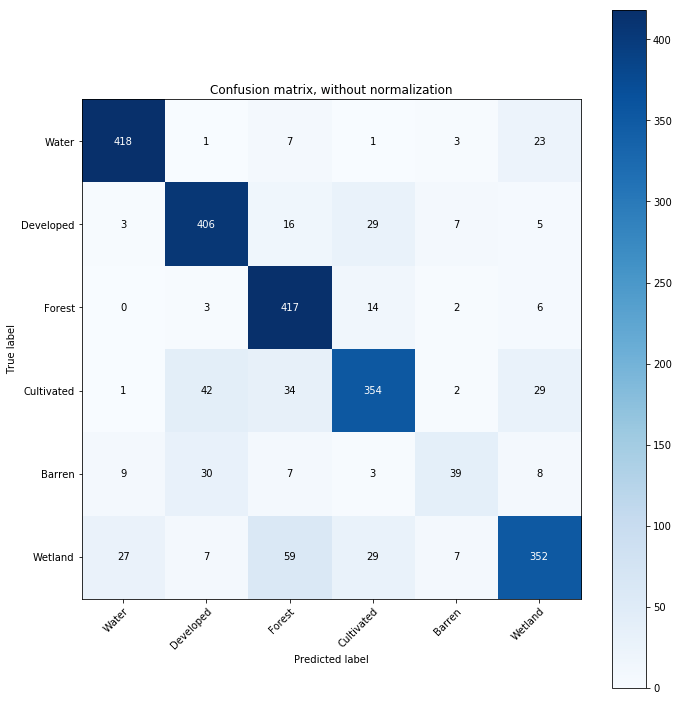

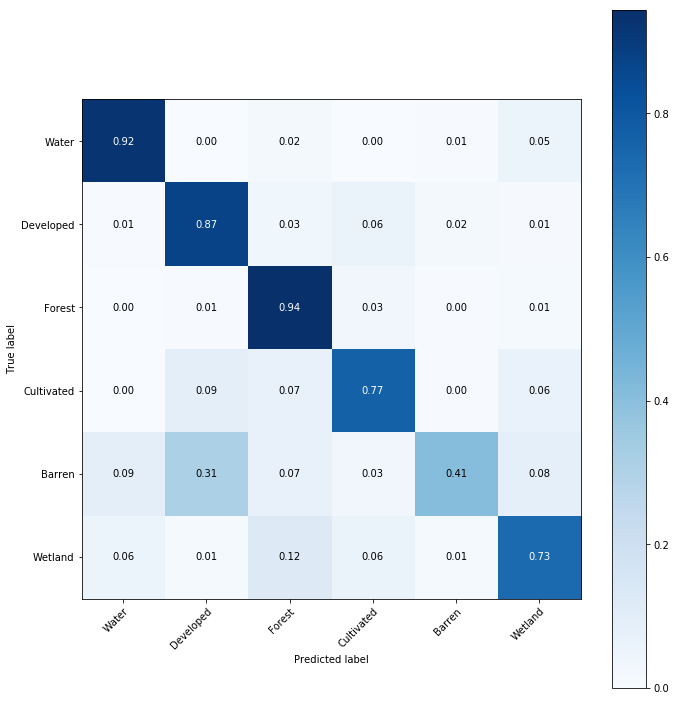

In [46]:
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
util.plot_confusion_matrix(label_index.astype(np.int), pred_index.astype(np.int), classes=np.array(list(util.indexed_dictionary)),
                      class_dict=util.indexed_dictionary)
# Plot normalized confusion matrix
util.plot_confusion_matrix(label_index.astype(np.int), pred_index.astype(np.int), classes=np.array(list(util.indexed_dictionary)),
                      class_dict=util.indexed_dictionary,
                      normalize=True,
                          title=" ")
count = 0
for i in range(len(label_index)):
    if(label_index[i] == pred_index[i]):
        count+=1
print("Accuracy is {}".format(count/len(label_index)))

plt.savefig("confusion_matrix.png", dpi=1000)

In [47]:
total = 0
tot = 0
for count in range(len(canopy_pred)):
    if canopy_true[count] != 0 and canopy_pred[count] !=0:
        if canopy_pred[count] < 0:
            canopy_pred[count] = 0
        total+= np.absolute(canopy_pred[count] - canopy_true[count])
        tot+=1
print(total/tot)

[0.11]


In [ ]:
label_index.shape

In [ ]:
label_index, 

In [ ]:
import pandas as pd
pred_df = pd.DataFrame({'lc_pred': pred_index,
                        'lc_true': label_index,
                        'canopy_pred': canopy_pred.flatten(),
                        'canopy_true': canopy_true.flatten()})
pred_df[pred_df["lc_true"] == 0].head()

In [ ]:
sns.jointplot(x=pred_df['canopy_pred'][pred_df['lc_true']!=0], y=pred_df['canopy_true'][pred_df['lc_true']!=0], kind='scatter')

In [ ]:
x=pred_df['canopy_pred'][pred_df['lc_true']!=0]
y=pred_df['canopy_true'][pred_df['lc_true']!=0]

from scipy.stats import gaussian_kde

xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

#ax.set_xlabel("Predictions")
#ax.set_ylabel("Annotations")
#ax.set_title("Canopy Cover Predictions")

g = sns.jointplot(x,y, kind='scatter', alpha=0.2)
#g.ax_joint.scatter(x=pred_df['canopy_pred'][pred_df['lc_true']!=0], y=pred_df['canopy_true'][pred_df['lc_true']!=0])
g.ax_joint.set_xticks(np.linspace(0,1,6))
g.ax_joint.set_xlabel("")
g.ax_joint.set_ylabel("")

plt.savefig("canopy_regression.png", dpi=1000)

In [ ]:
plt.hist(canopy_pred)

In [ ]:
plt.hist(canopy_true)

In [ ]:
from scipy.stats import gaussian_kde

#x = (canopy_pred * 100).flatten()
#y = (canopy_true * 100).flatten()

x=pred_df['canopy_pred'][pred_df['lc_true']!=0]
y=pred_df['canopy_true'][pred_df['lc_true']!=0]

xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

idx = z.argsort()
plt.rcParams.update({'font.size': 18})
fig,ax = plt.subplots()
im = ax.scatter(x,y,c=z,s=50,edgecolor='', alpha=0.7, cmap="nipy_spectral")
ax.set_xticks(np.linspace(0,1,6))
#ax.set_xlabel("Predictions")
#ax.set_ylabel("Annotations")
#ax.set_title("Canopy Cover Predictions")
plt.colorbar(im, ax=ax)
plt.savefig("canopy_regression.png", dpi=1000)

In [ ]:
plt.hist(pred_df['canopy_pred'][pred_df['lc_true']!=0])
plt.hist(pred_df['canopy_true'][pred_df['lc_true']!=0])

In [ ]:
plt.scatter(canopy_pred, canopy_true)
plt.xlabel("Canopy Fraction Predictions")
plt.ylabel("Canopy Fraction Annotations")
plt.savefig("canopy_regression.png", dpi=1000)

In [ ]:
from sklearn.metrics import r2_score
r2_score(canopy_true, canopy_pred)

In [ ]:
# library & dataset
import seaborn as sns
df = sns.load_dataset('iris')
 

sns.jointplot(y=(canopy_true*100).flatten(), x=(canopy_pred*100).flatten(), kind='scatter')
sns.jointplot(x=(canopy_true*100).flatten(), y=(canopy_pred*100).flatten(), kind='hex')
sns.jointplot(x=(canopy_true*100).flatten(), y=(canopy_pred*100).flatten(), kind='kde')
#plt.savefig("canopy_reg_dist_cont.png", dpi=1000)